# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1) Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.<br>
2) Подобная система имеет плохую устойчивость к шумам.<br>
3) По какому принципу вибирать нужные эталоны?<br>
4) Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесеней?<br>
5) Чем больше эталонов, тем алгоритм вычислительнозатратен.<br>

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:

<b>YES</b>  SIL Y EH1 S SIL<br>
<b>NO</b>  SIL N OW1 SIL<br>

Словарь для цифр (data/lexicon_digits.txt):

<b>ZERO</b>  SIL Z IH1 R OW0 SIL<br>
<b>ZERO</b>  SIL Z IY1 R OW0 SIL<br>
<b>ONE</b>  SIL W AH1 N SIL<br>
<b>ONE</b>  SIL HH W AH1 N SIL<br>
<b>TWO</b>  SIL T UW1 SIL<br>
<b>THREE</b>  SIL TH R IY1 SIL<br>
<b>FOUR</b>  SIL F AO1 R SIL<br>
<b>FIVE</b>  SIL F AY1 V SIL<br>
<b>SIX</b>  SIL S IH1 K S SIL<br>
<b>SEVEN</b>  SIL S EH1 V AH0 N SIL<br>
<b>EIGHT</b>  SIL EY1 T SIL<br>
<b>NINE</b>  SIL N AY1 N SIL<br>

SIL здесь – это фонема паузы.
Как вы возможно заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для нее вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем назвать это акустической моделью.

### Данные для обучения

Наша задача собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных librispeech (аудиозаписи чтения книг на английском). Для этого предварительно мной была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...<br>
   filename2 phone_frame1 phone_frame2 phone_frame3 ...</b> 
   
Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K
K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N
N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI
L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1
 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>
 
Аудио файлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir"

### Bootstrap

In [1]:
import os
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# рассмотрим пример такой записи:
wav_example = 'resources/train_librispeech_10h/wav_dir/1183-124566-0003.flac'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print('Number of samples: {}'.format(len(x)))
print('Sampling rate: {} Hz'.format(sr))
print('Duration: {:.2f} s'.format(len(x)/sr))  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 45680
Sampling rate: 16000 Hz
Duration: 2.85 s


Text(0.5, 1.0, 'Log-frequency power spectrogram')

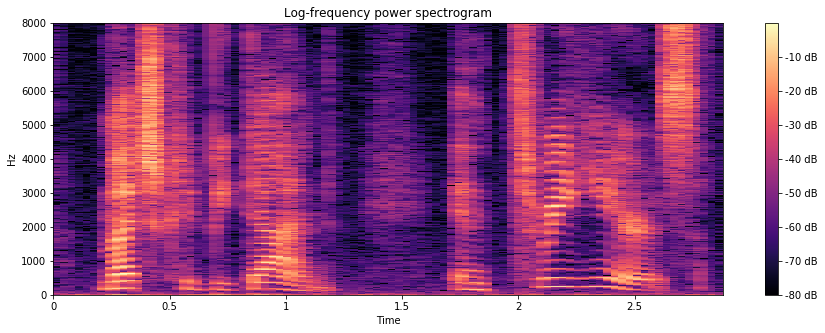

In [3]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
plt.figure(figsize=(15,5))
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

### Подготовка данных

In [4]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'resources/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

In [5]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = 'resources/train_librispeech_10h/wav_dir'
train_data_dict = load_data_dict(train_records_dir, count=100)

Early stop at 100th file..



In [6]:
# инициализация списка допустимых фонем из предустановленного файла
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = 'resources/train_librispeech_10h/phones'
phones_dict = init_phones_dict(phones_file)

In [7]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 22241
SPN: 1213
AA : 0
AA0: 34
AA1: 1748
AA2: 114
AE : 0
AE0: 29
AE1: 3502
AE2: 63
AH : 0
AH0: 6005
AH1: 2283
AH2: 80
AO : 0
AO0: 35
AO1: 2117
AO2: 95
AW : 0
AW0: 0
AW1: 991
AW2: 43
AY : 0
AY0: 114
AY1: 2721
AY2: 133
B  : 1643
CH : 1105
D  : 3937
DH : 2129
EH : 0
EH0: 50
EH1: 3070
EH2: 79
ER : 0
ER0: 3051
ER1: 946
ER2: 6
EY : 0
EY0: 21
EY1: 2329
EY2: 175
F  : 2441
G  : 855
HH : 1892
IH : 0
IH0: 2748
IH1: 2505
IH2: 142
IY : 0
IY0: 2358
IY1: 2078
IY2: 61
JH : 628
K  : 3213
L  : 4171
M  : 3192
N  : 6328
NG : 1222
OW : 0
OW0: 178
OW1: 1718
OW2: 127
OY : 0
OY0: 0
OY1: 172
OY2: 0
P  : 2384
R  : 3953
S  : 6865
SH : 1598
T  : 6424
TH : 703
UH : 0
UH0: 3
UH1: 407
UH2: 17
UW : 0
UW0: 73
UW1: 1681
UW2: 49
V  : 1785
W  : 2301
Y  : 722
Z  : 3224
ZH : 84
Number of empty phones is: 18


In [8]:
# соберем статистику на основе среднего значения для каждой фонемы
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

### Инициализация фонемного графа

In [9]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = 'resources/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [10]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

    
class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, mean_phones_value):
    start_state = State(AcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, mean_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    with open('resources/result-lab-02-03/graph_mean.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE resources/result-lab-02-03/graph_mean.txt ***")

In [11]:
graph = load_graph(lexicon_dict, mean_phones_value)
print_graph(graph)

*** SEE resources/result-lab-02-03/graph_mean.txt ***


In [12]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold, status=True):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    #for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата DTW
    if status:
        print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [13]:
def run_recognizer(records_data_dict, graph, beam_threshold=10, status=False):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename], graph, recognition_results, beam_threshold, status)
    
    WER = round((1 - sum(recognition_results)/len(recognition_results))*100, 2)
    timer = round(time.time() - start_time, 2)
    if status:
        print("-" * 60)
        print(f"WER is: {WER:.2f}%")
        print(f"Total time is: {timer:.2f} sec")
        print("-" * 60)
    return WER, timer

In [14]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T
    
    return data_dict

### Запустим наше распознавание на базе YES_NO

In [15]:
lexicon_file = 'resources/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("resources/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=5, status=True);
result_yes_no_mean = pd.DataFrame(columns=['WER', 'time'])
for i in tqdm(range(1, 21, 1)):
    result_yes_no_mean.loc[i] = run_recognizer(records_data_dict, graph, beam_threshold=i, status=False)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.06 sec
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [16]:
lexicon_file = 'resources/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("resources/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=100, status=True);
result_digits_mean = pd.DataFrame(columns=['WER', 'time'])
for i in tqdm(range(1, 500, 50)):
    result_digits_mean.loc[i] = (run_recognizer(records_data_dict, graph, beam_threshold=i, status=False))

result: zero_f852895b_nohash_0.wav  ==> THREE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: zero_f92e49f3_nohash_3.wav  ==> THREE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: eight_daf230ac_nohash_0.wav ==> THREE
result: three_feb1d305_nohash_0.wav ==> FIVE
result: four_fce65496_nohash_0.wav  ==> ONE
result: seven_fd32732a_nohash_0.wav ==> SEVEN
result: seven_fe5c4a7a_nohash_0.wav ==> THREE
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: eight_da584bc0_nohash_4.wav ==> SEVEN
result: five_f852895b_nohash_0.wav  ==> THREE
result: two_fce65496_nohash_0.wav   ==> SIX
result: three_fce96bac_nohash_0.wav ==> FIVE
result: six_ffbb695d_nohash_0.wav   ==> FIVE
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: one_ffa76c4a_nohash_0.wav   ==> ONE
------------------------------------------------------------
WER is: 55.00%
Total time is: 0.28 sec

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

In [17]:
phones_dict_stripped = init_phones_dict(phones_file)

for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    file_ali_df = pd.Series(file_ali)
    label = file_ali[0]
    ignore_index = []
    for i in file_ali_df[~((file_ali_df) == file_ali_df.shift(1))].index:
        ignore_index.extend(list(np.linspace(i - 4, i + 4, 4 * 2 + 1)))
    for frame in range(min(len(file_feats), len(file_ali))):
        if frame in ignore_index:
            continue
        phones_dict_stripped[file_ali[frame]].append(file_feats[frame])
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict_stripped.keys():
    if len(phones_dict_stripped[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict_stripped[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 16852
SPN: 1024
AA : 0
AA0: 5
AA1: 444
AA2: 21
AE : 0
AE0: 0
AE1: 966
AE2: 8
AH : 0
AH0: 328
AH1: 330
AH2: 17
AO : 0
AO0: 3
AO1: 724
AO2: 24
AW : 0
AW0: 0
AW1: 440
AW2: 10
AY : 0
AY0: 52
AY1: 1122
AY2: 44
B  : 146
CH : 369
D  : 343
DH : 52
EH : 0
EH0: 1
EH1: 430
EH2: 4
ER : 0
ER0: 847
ER1: 363
ER2: 0
EY : 0
EY0: 3
EY1: 743
EY2: 48
F  : 526
G  : 84
HH : 184
IH : 0
IH0: 156
IH1: 350
IH2: 10
IY : 0
IY0: 624
IY1: 498
IY2: 6
JH : 126
K  : 548
L  : 645
M  : 443
N  : 804
NG : 225
OW : 0
OW0: 54
OW1: 605
OW2: 51
OY : 0
OY0: 0
OY1: 91
OY2: 0
P  : 382
R  : 480
S  : 2018
SH : 537
T  : 891
TH : 142
UH : 0
UH0: 0
UH1: 58
UH2: 2
UW : 0
UW0: 15
UW1: 536
UW2: 7
V  : 130
W  : 251
Y  : 89
Z  : 600
ZH : 15
Number of empty phones is: 21


In [18]:
df = pd.DataFrame()
y = []
for i in ['Y', 'EH1', 'S', 'N', 'OW1']:
    df = df.append(phones_dict_stripped[i], ignore_index=True)
    y.extend([i] * len(phones_dict_stripped[i]))

In [19]:
feat_cols = ['mfcc_' + str(i) for i in range(phones_dict['OW1'][0].shape[0])]
df.columns = feat_cols
df['label'] = y
df.head(5)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,label
0,-505.252441,80.936691,18.196968,43.437153,-54.390045,-18.926243,-0.112589,-56.366028,-10.361414,-5.327990,-18.756081,-30.349167,-24.339277,Y
1,-503.584137,78.201065,33.636997,47.513367,-54.903778,-14.705177,1.492641,-42.617756,-5.996319,-11.438723,-16.698643,-36.455429,-15.983983,Y
2,-505.114380,74.938820,44.906593,60.986618,-67.595551,-8.414927,3.338374,-28.043411,-5.017463,-13.039764,-14.661697,-25.356796,-7.290092,Y
3,-479.859467,50.588772,48.538841,71.925751,-52.940296,4.035403,-11.810024,-41.372990,-5.347956,-16.394821,-19.330124,-36.590370,0.098803,Y
4,-457.372070,39.643044,51.278858,64.872101,-38.447277,5.914004,-8.058400,-46.679516,-17.007572,-23.258188,-9.869389,-36.543335,7.430628,Y


In [20]:
limit = df['label'].value_counts().min()
label = df['label'].value_counts().index

In [21]:
df_limit = pd.DataFrame()
for index in label:
    df_limit = df_limit.append(df[df['label'] == index].iloc[:limit])
df_limit.head(5)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,label
519,-463.122650,-52.319611,60.100201,18.679520,16.358835,-0.653464,-20.003162,22.505972,-5.144085,-6.553701,-10.608549,-7.833186,-4.180429,S
520,-482.444305,-49.867973,58.679787,8.414074,13.867334,-4.363702,-23.955515,11.257780,-19.419073,5.396314,5.989342,18.065815,8.119892,S
521,-476.057831,-32.427826,58.784874,-22.020786,7.149578,-4.073619,-27.039715,19.146137,14.285100,15.585041,-1.692224,0.736271,9.002768,S
522,-427.571991,-56.213913,43.139259,4.074409,-18.708614,30.558422,-2.522451,12.447371,26.092676,6.079767,0.771193,-19.019169,-2.292863,S
523,-465.489716,-87.455139,67.410568,31.202419,24.693489,10.152006,30.005009,21.256725,17.003138,-4.807317,5.354421,9.345764,6.988232,S


In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_limit[feat_cols].values)
df_limit['pca-one'] = pca_result[:,0]
df_limit['pca-two'] = pca_result[:,1] 
df_limit['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.6  0.3  0.0]


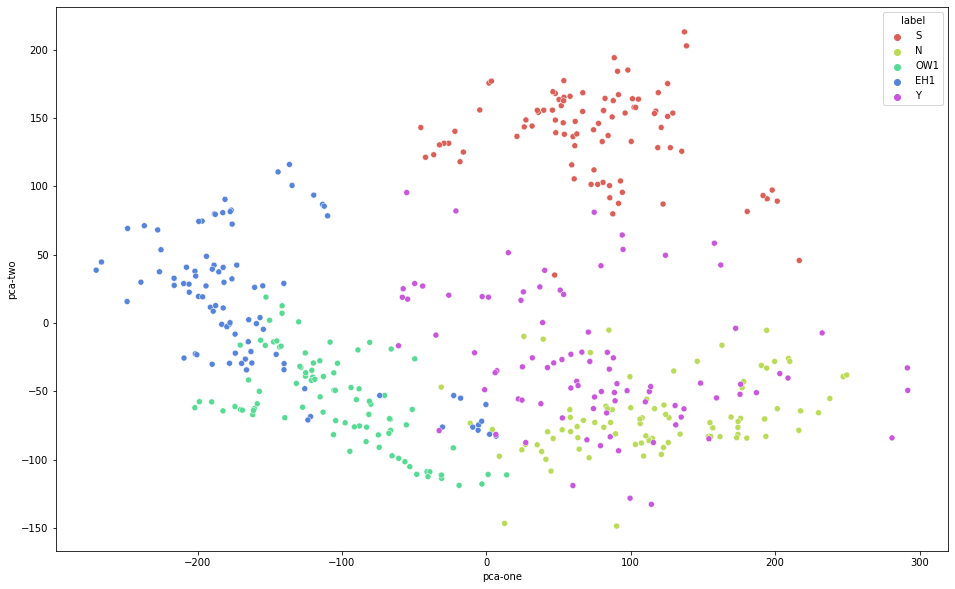

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df_limit,
    legend="full",
    alpha=1
);

In [24]:
df_subset = df_limit.copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.6  0.3  0.0]


In [25]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 445 samples in 0.001s...
[t-SNE] Computed neighbors for 445 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 445 / 445
[t-SNE] Mean sigma: 17.634918
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.514191
[t-SNE] KL divergence after 500 iterations: 0.322004
t-SNE done! Time elapsed: 15.272245168685913 seconds


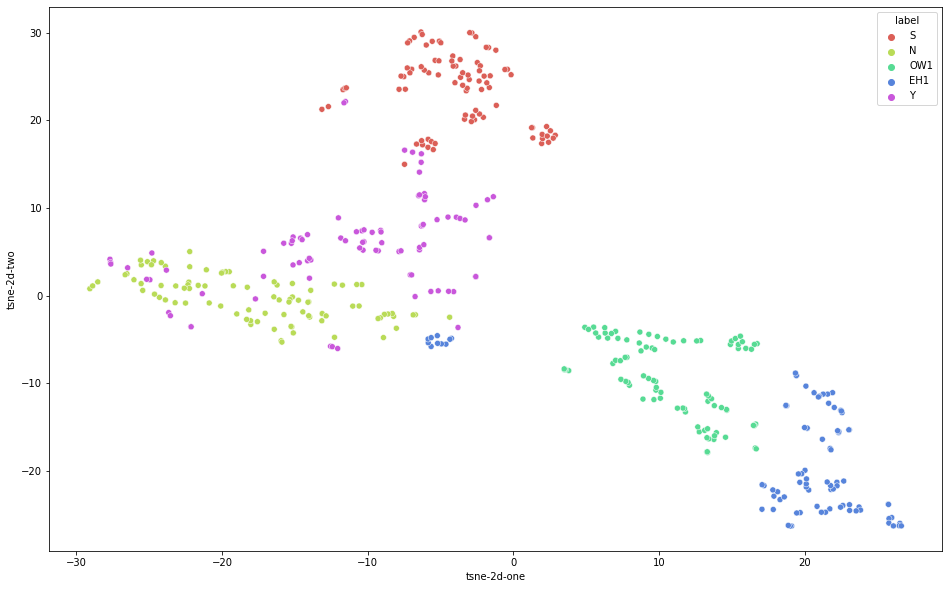

In [26]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df_subset,
    legend="full",
    alpha=1
);

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в роле дистанции нам нужно брать значение -log(x), где x -- предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

In [27]:
gm_phones_value = {}
for phone in tqdm(phones_dict.keys()):
    if phones_dict[phone]:
        gm_phones_value[phone] = GaussianMixture(n_components=3, random_state=0).fit(np.array(phones_dict[phone]))

In [28]:
class GmmAcousticModel:
    def __init__(self, phone_name, phone_gmm_model):
        self.phone_name = phone_name
        self.phone_gmm_model = phone_gmm_model
    def distance(self, input_feats):
        return -self.phone_gmm_model.score([input_feats])

In [29]:
def load_graph(lexicon_dict, gm_phones_value):
    start_state = State(GmmAcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(GmmAcousticModel(phone, gm_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    with open('resources/result-lab-02-03/graph_gmm.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE resources/result-lab-02-03/graph_gmm.txt ***")

In [30]:
lexicon_file = 'resources/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gm_phones_value)
print_graph(graph)
records_data_dict = load_data_dict("resources/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=10, status=True)
result_yes_no_gmm = pd.DataFrame(columns=['WER', 'time'])
for i in tqdm(range(1, 21, 1)):
    result_yes_no_gmm.loc[i] = (run_recognizer(records_data_dict, graph, beam_threshold=i, status=False))

*** SEE resources/result-lab-02-03/graph_gmm.txt ***
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.69 sec
------------------------------------------------------------


In [31]:
lexicon_file = 'resources/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gm_phones_value)
records_data_dict = load_data_dict("resources/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=100, status=True)
result_digits_gmm = pd.DataFrame(columns=['WER', 'time'])
for i in tqdm(range(1, 500, 50)):
    result_digits_gmm.loc[i] = (run_recognizer(records_data_dict, graph, beam_threshold=i, status=False))

result: zero_f852895b_nohash_0.wav  ==> SEVEN
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: zero_f92e49f3_nohash_3.wav  ==> SEVEN
result: one_fc2411fe_nohash_0.wav   ==> NINE
result: eight_daf230ac_nohash_0.wav ==> EIGHT
result: three_feb1d305_nohash_0.wav ==> SIX
result: four_fce65496_nohash_0.wav  ==> FOUR
result: seven_fd32732a_nohash_0.wav ==> EIGHT
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: nine_ccea893d_nohash_0.wav  ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> SIX
result: five_f852895b_nohash_0.wav  ==> FIVE
result: two_fce65496_nohash_0.wav   ==> TWO
result: three_fce96bac_nohash_0.wav ==> TWO
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: one_ffa76c4a_nohash_0.wav   ==> FOUR
------------------------------------------------------------
WER is: 45.00%
Total time is: 15.36 sec


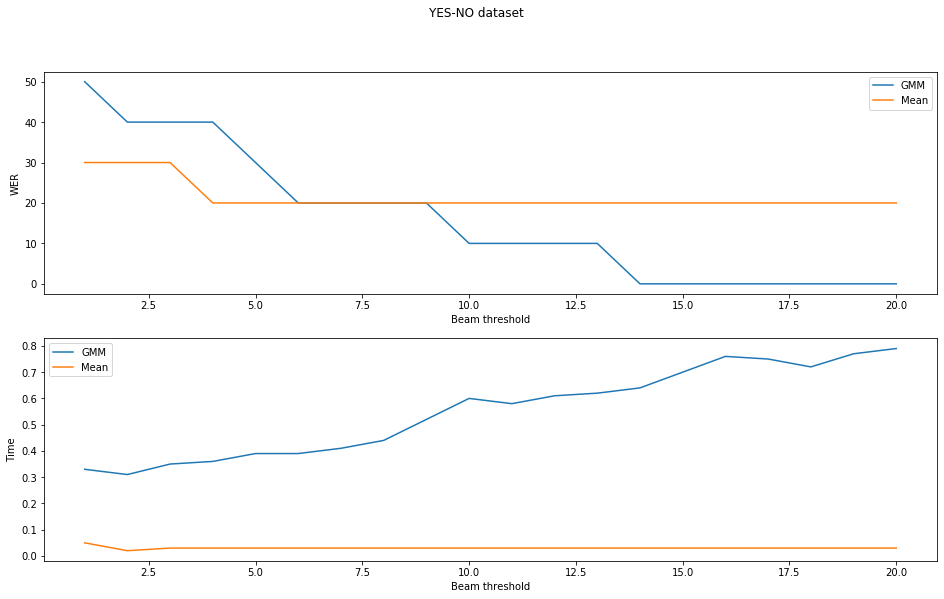

In [32]:
f, axs = plt.subplots(2, 1,figsize=(16, 9))
axs[0].plot(result_yes_no_gmm.index, result_yes_no_gmm['WER'], label='GMM')
axs[0].plot(result_yes_no_mean.index, result_yes_no_mean['WER'], label='Mean')
axs[0].set_xlabel('Beam threshold')
axs[0].set_ylabel('WER')
axs[0].legend()

axs[1].plot(result_yes_no_gmm.index, result_yes_no_gmm['time'], label='GMM')
axs[1].plot(result_yes_no_mean.index, result_yes_no_mean['time'], label='Mean')
axs[1].set_xlabel('Beam threshold')
axs[1].set_ylabel('Time')
axs[1].legend()

f.suptitle('YES-NO dataset')
plt.show()

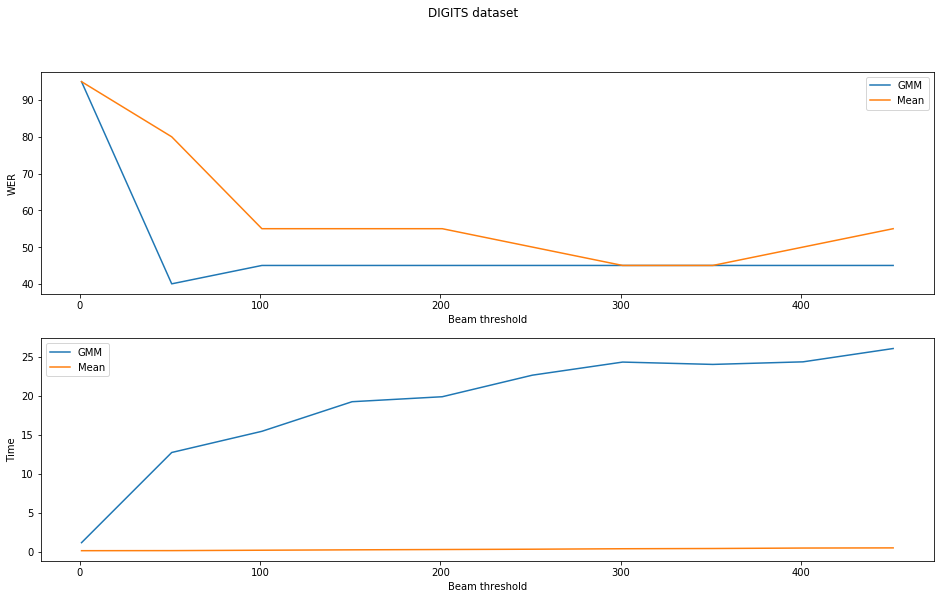

In [33]:
f, axs = plt.subplots(2, 1,figsize=(16, 9))
axs[0].plot(result_digits_gmm.index, result_digits_gmm['WER'], label='GMM')
axs[0].plot(result_digits_mean.index, result_digits_mean['WER'], label='Mean')
axs[0].set_xlabel('Beam threshold')
axs[0].set_ylabel('WER')
axs[0].legend()

axs[1].plot(result_digits_gmm.index, result_digits_gmm['time'], label='GMM')
axs[1].plot(result_digits_mean.index, result_digits_mean['time'], label='Mean')
axs[1].set_xlabel('Beam threshold')
axs[1].set_ylabel('Time')
axs[1].legend()

f.suptitle('DIGITS dataset')
plt.show()

* Выводы: как можно увидеть по графикам оптимально подбирая порог пруннинга, алгоритм Token-passing на GMM показывает качество лучше, чем на усреднении признаков. Однако и скорость работы алгоритмы сильно возрасла.